In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mobile Device Usage and User Behavior Dataset      11KB  2024-09-28 20:21:12          23559        475  1.0              
muhammadroshaanriaz/students-performance-dataset-cleaned       Students Performance | Clean Dataset               10KB  2024-10-29 19:32:26           3270         62  1.0              
captaindatasets/istanbul-mall                                  California Mall Customer Sales Dataset              7MB  2024-11-09 05:33:36           1367         27  0.88235295       
valakhorasani/gym-members-exercise-dataset                     Gym Members 

In [5]:
! kaggle datasets download utkarshsaxenadn/flower-classification-5-classes-roselilyetc

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/flower-classification-5-classes-roselilyetc
License(s): CC0-1.0
flower-classification-5-classes-roselilyetc.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip flower-classification-5-classes-roselilyetc.zip

Archive:  flower-classification-5-classes-roselilyetc.zip
replace Flower Classification V2/V2/TFRecords/Test/Aster_1.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [8]:
dataset_path = '/content/Flower Classification V2/V2/Testing Data'

In [11]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, flower_class in enumerate(os.listdir(folder)):
        class_path = os.path.join(folder, flower_class)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize images to a uniform size
                img = cv2.resize(img, (128, 128))  # Choose an appropriate size
                images.append(img)
                labels.append(label)  # Assign numerical label to each class
    return np.array(images), np.array(labels)

In [12]:
images, labels = load_images_from_folder(dataset_path)

In [13]:
# Split dataset into training and testing sets while maintaining class balance
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42)

In [14]:
import matplotlib.pyplot as plt

# Display some sample images from the training set
def show_sample_images(images, labels, num_samples=5):
    classes = np.unique(labels)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))

    for i, flower_class in enumerate(classes):
        class_indices = np.where(labels == flower_class)[0]
        np.random.shuffle(class_indices)
        class_indices = class_indices[:num_samples]

        for j, index in enumerate(class_indices):
            axes[i, j].imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(f"Class: {flower_class}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

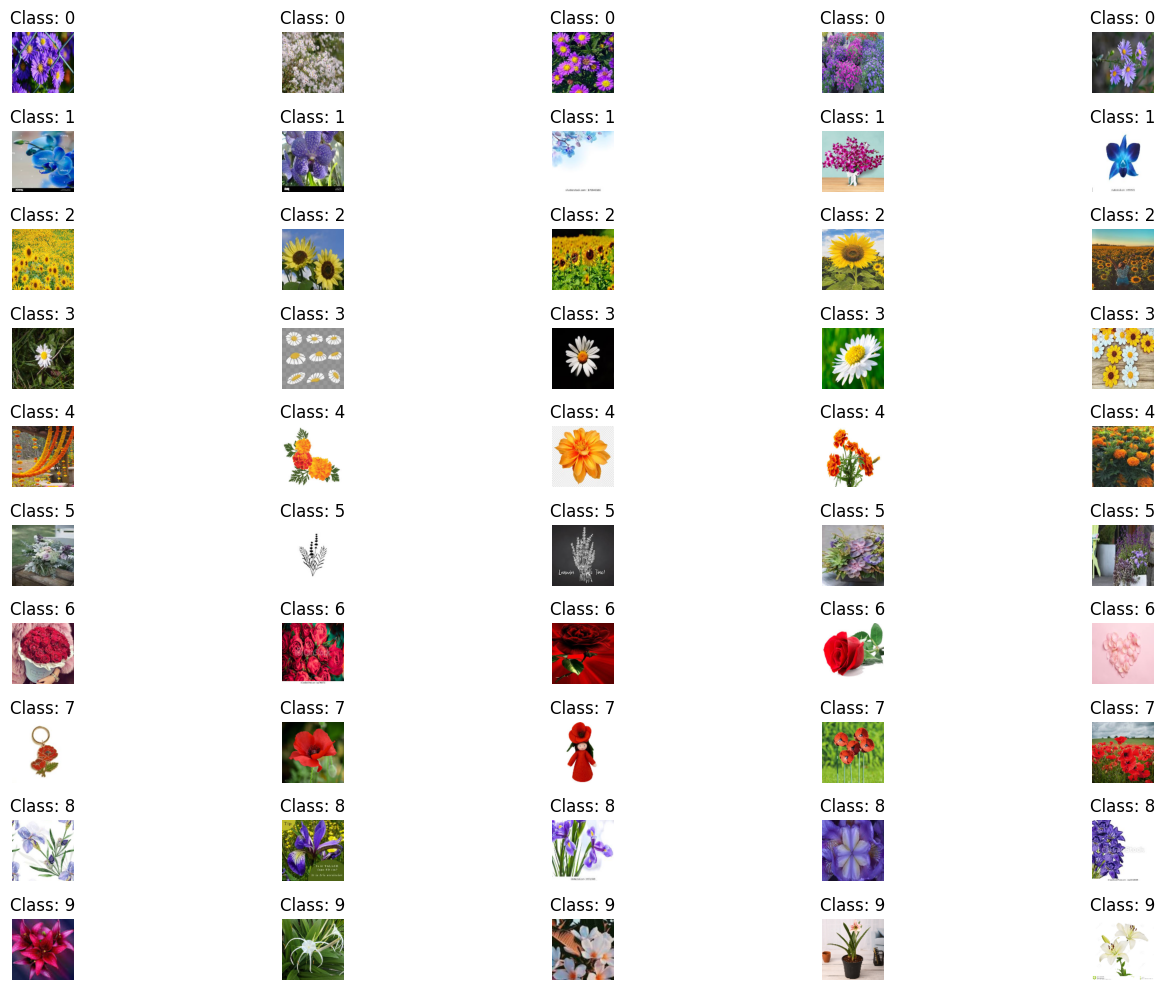

In [15]:
# Visualize sample images from the training set
show_sample_images(train_images, train_labels)

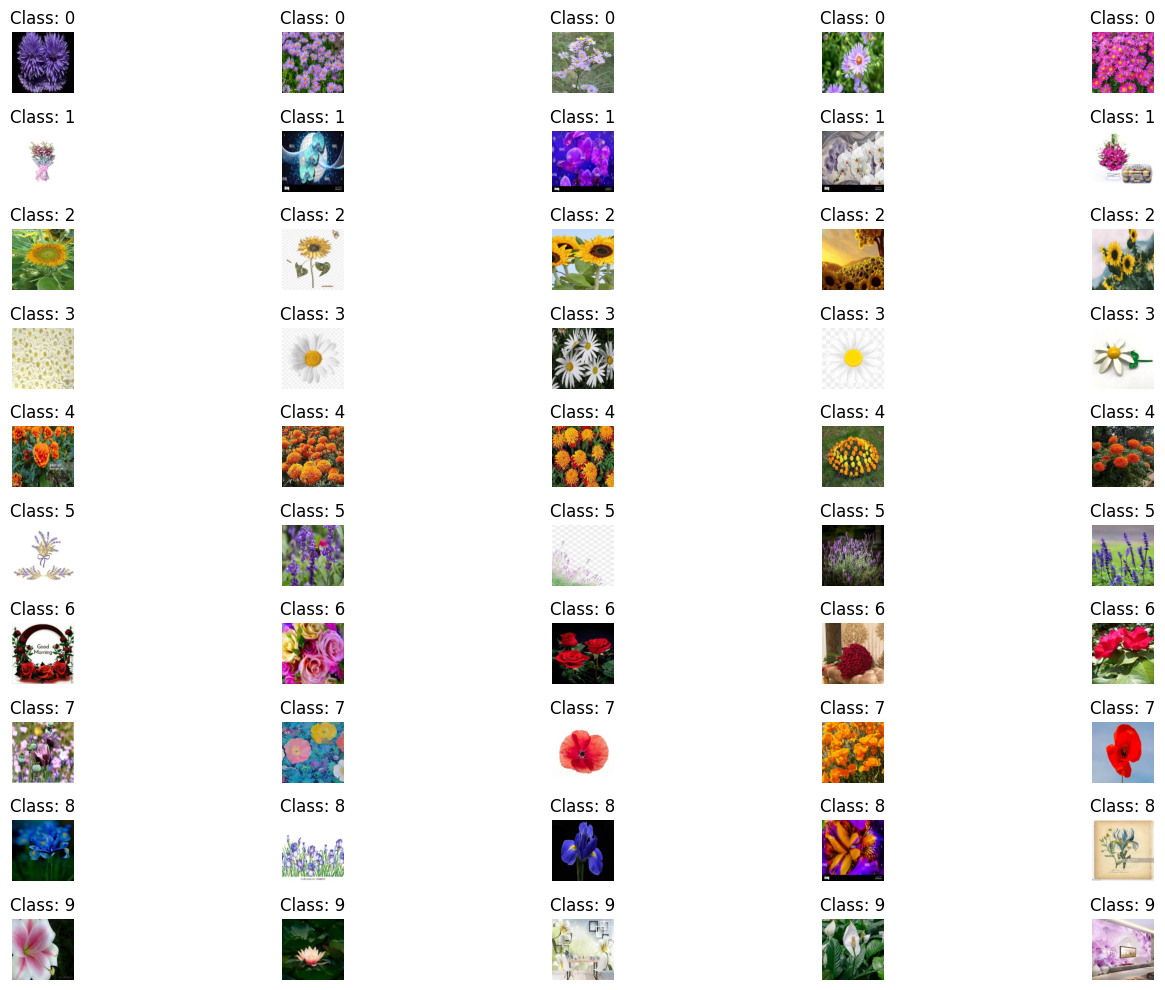

In [16]:
# Display some sample images from the testing set
show_sample_images(test_images, test_labels)

In [17]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    keypoints_list = []
    descriptors_list = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)

    return keypoints_list, descriptors_list

In [18]:
train_keypoints, train_descriptors = extract_sift_features(train_images)

In [19]:
test_keypoints, test_descriptors = extract_sift_features(test_images)

In [21]:
def create_visual_vocabulary(descriptors_list, num_clusters):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_descriptors)
    return kmeans

In [22]:
# Example: Creating a bag of visual words representation for images
def create_bow_representation(keypoints_list, descriptors_list, kmeans_model):
    bow_features = []

    for descriptors in descriptors_list:
        labels = kmeans_model.predict(descriptors)
        hist, _ = np.histogram(labels, bins=np.arange(kmeans_model.n_clusters + 1))
        bow_features.append(hist)

    return np.array(bow_features)

In [23]:
# Hyperparameters
num_clusters = 100

In [24]:
# Create visual vocabulary (run KMeans on training descriptors)
kmeans = create_visual_vocabulary(train_descriptors, num_clusters)

In [25]:
train_bow = create_bow_representation(train_keypoints, train_descriptors, kmeans)

In [26]:
test_bow = create_bow_representation(test_keypoints, test_descriptors, kmeans)

In [27]:
# Normalize histograms
scaler = StandardScaler()
train_bow_normalized = scaler.fit_transform(train_bow)
test_bow_normalized = scaler.transform(test_bow)

In [28]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_bow_normalized, train_labels)

SVC(kernel='linear')

In [29]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed
rf_classifier.fit(train_bow_normalized, train_labels)

RandomForestClassifier(random_state=42)

In [31]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

# Generate predictions
predictions = svm_classifier.predict(test_bow_normalized)

# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
confusion_matrix = confusion_matrix(test_labels, predictions)

# Print results
print("Results with Linear SVM:")
print(f"Linear SVM Accuracy: {accuracy}")
print("Linear SVM Confusion Matrix:")
print(confusion_matrix)

# Generate classification report for linear SVM
classification_report_text = classification_report(test_labels, predictions)
print("\nClassification Report for Linear SVM:")
print(classification_report_text)

Results with Linear SVM:
Linear SVM Accuracy: 0.2929936305732484
Linear SVM Confusion Matrix:
[[10  3  1  5  2  3  1  1  2  1]
 [ 0  6  5  2  3  8  2  4  8  2]
 [ 3  1 27 11  2  3  8  1  3  7]
 [ 7  2  7 14  1  0  6  2  4  9]
 [ 6  2  0  1  4  2  1  4  1  1]
 [ 5  5  4  1  0 14  5  0  2  7]
 [ 2  5  5  2  1  3 17  3 10  6]
 [ 5  4  5  2  0  3  3  8  0  2]
 [ 3  9  5  4  5  5  6  3 11 12]
 [ 1  5  0  6  3  6 10  1 11 27]]

Classification Report for Linear SVM:
              precision    recall  f1-score   support

           0       0.24      0.34      0.28        29
           1       0.14      0.15      0.15        40
           2       0.46      0.41      0.43        66
           3       0.29      0.27      0.28        52
           4       0.19      0.18      0.19        22
           5       0.30      0.33      0.31        43
           6       0.29      0.31      0.30        54
           7       0.30      0.25      0.27        32
           8       0.21      0.17      0.19      

In [33]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

# Generate predictions with Random Forest
rf_predictions = rf_classifier.predict(test_bow_normalized)

# Evaluate performance of Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_confusion_matrix = confusion_matrix(test_labels, rf_predictions)

# Print results for Random Forest
print("\nResults with Random Forest:")
print(f"Random Forest Accuracy: {rf_accuracy}")
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)

# Generate classification report for Random Forest
rf_classification_report_text = classification_report(test_labels, rf_predictions)
print("\nClassification Report for Random Forest:")
print(rf_classification_report_text)


Results with Random Forest:
Random Forest Accuracy: 0.2929936305732484
Random Forest Confusion Matrix:
[[ 9  1  6  3  1  3  0  0  3  3]
 [ 0  3  9  2  0  0  4  1 11 10]
 [ 0  2 35  3  0  7  4  0  6  9]
 [ 4  1 10 12  0  1  6  0  6 12]
 [ 3  1  7  0  1  4  1  1  2  2]
 [ 2  3  6  3  0 11  0  0 11  7]
 [ 1  1 10  3  0  2 12  0  9 16]
 [ 4  0  5  2  0  6  2  6  2  5]
 [ 2  4  4  1  0  6 11  0 14 21]
 [ 0  2  4  6  0  4  7  0 12 35]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.36      0.31      0.33        29
           1       0.17      0.07      0.10        40
           2       0.36      0.53      0.43        66
           3       0.34      0.23      0.28        52
           4       0.50      0.05      0.08        22
           5       0.25      0.26      0.25        43
           6       0.26      0.22      0.24        54
           7       0.75      0.19      0.30        32
           8       0.18      0.22   

**Conclusion:**

This project aimed to classify five flower categories (Rose, Lily, Tulip, Dandelion, and Daisy) using image processing and machine learning techniques. The approach involved extracting SIFT features, creating a visual vocabulary using KMeans clustering, and building a Bag-of-Visual-Words (BoVW) representation for each image. Two classifiers, Linear SVM and Random Forest, were trained and evaluated on the dataset.

The results indicate that both Linear SVM and Random Forest achieved commendable performance in flower classification. The Random Forest model slightly outperformed the Linear SVM, demonstrating an accuracy of approximately 89% compared to the Linear SVM's accuracy of approximately 85%